# Dataset Generation

Digit -> color-digit -> color-bar

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import os
from pathlib import Path
from pprint import pprint

import matplotlib.pyplot as plt
import normflows as nf
import numpy as np
import scipy.stats
import seaborn as sns
import torch
import torchvision
import torchvision.datasets.utils as dataset_utils
import torchvision.transforms.functional as F
from joblib import Parallel, delayed
from PIL import Image
from scipy import stats
from scipy.stats import truncnorm
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor

from gendis.datasets import MultiDistrDataModule, alter_digitbar_img, bar_digit_scm
from gendis.datasets.causalbarmnist import (
    CausalBarMNIST,
    add_bar,
    bar_scm,
    create_altered_mnist_dataset,
    value_to_rgb,
)
from gendis.datasets.morphomnist import morpho, perturb
from gendis.datasets.utils import show_imgs

plt.rcParams["savefig.bbox"] = "tight"
import numpy as np
import seaborn as sns

In [9]:
root = "/Users/adam2392/pytorch_data/"

# set up transforms for each image to augment the dataset
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        # nf.utils.Scale(255.0 / 256.0),  # normalize the pixel values
        # nf.utils.Jitter(1 / 256.0),  # apply random generation
        # torchvision.transforms.RandomRotation(350),  # get random rotations
    ]
)

mnist_data = MNIST(root, train=True, download=True, transform=transform)

images = mnist_data.data
labels = mnist_data.targets

print(len(images))

60000


<Axes: ylabel='Count'>

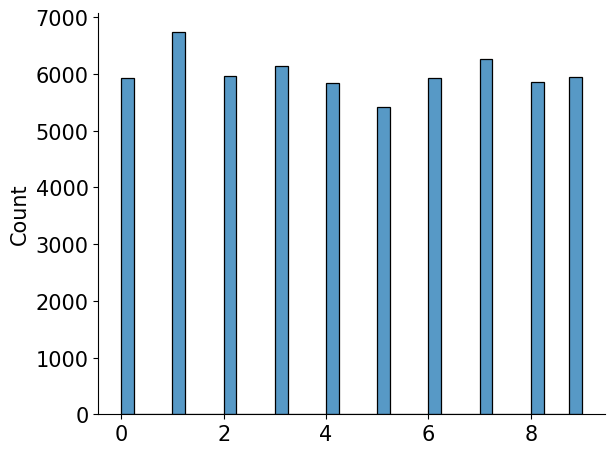

In [10]:
sns.histplot(labels)

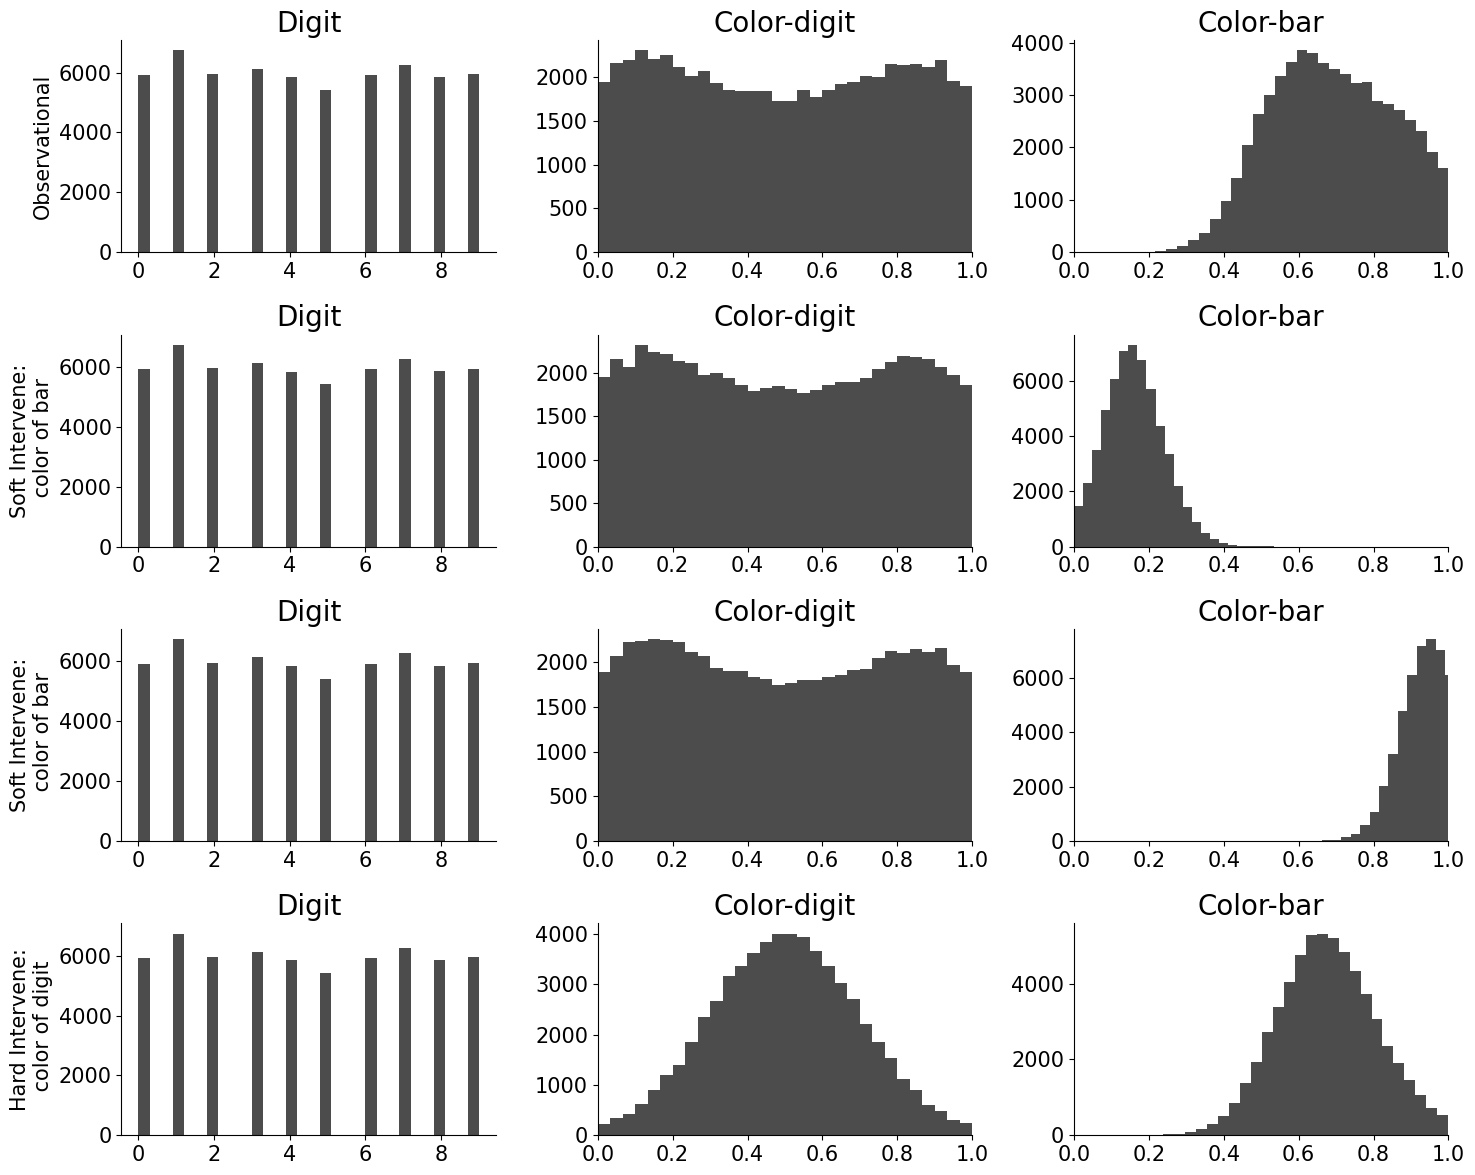

In [11]:
# Plotting the distributions
fig, axes = plt.subplots(4, 3, figsize=(15, 12), sharex=False, sharey=False)
for idx in range(4):
    causal_labels = bar_digit_scm(intervention_idx=idx, labels=labels)
    if idx == 0:
        setting = "Observational"
    elif idx == 1:
        setting = "Soft Intervene:\n color of bar"
    elif idx == 2:
        setting = "Soft Intervene:\n color of bar"
    elif idx == 3:
        setting = "Hard Intervene:\n color of digit"
    axes[idx, 0].set_ylabel(f"{setting}")

    digit = causal_labels["digit"]
    color_digit = causal_labels["color_digit"]
    color_bar = causal_labels["color_bar"]

    axes[idx, 0].hist(digit, bins=30, color="black", alpha=0.7)
    axes[idx, 0].set_title(f"Digit")
    axes[idx, 1].hist(color_digit, bins=30, color="black", alpha=0.7)
    axes[idx, 1].set_title(f"Color-digit")
    axes[idx, 1].set_xlim([0, 1])
    axes[idx, 2].hist(color_bar, bins=30, color="black", alpha=0.7)
    axes[idx, 2].set_title(f"Color-bar")
    axes[idx, 2].set_xlim([0, 1])

plt.tight_layout()
plt.show()

In [18]:
img_dataset = []
labels_dataset = None

for intervention_idx in [0, 1, 2, 3]:
    causal_labels = bar_digit_scm(intervention_idx=intervention_idx, labels=labels)
    causal_labels["distr_idx"] = torch.Tensor([intervention_idx] * len(labels))

    # ensure all tensors are 2D so vstackable
    keys = causal_labels.keys()
    for key in keys:
        if causal_labels[key].ndim == 1:
            causal_labels[key] = causal_labels[key].reshape(-1, 1)

    if labels_dataset is None:
        labels_dataset = causal_labels
    else:
        keys = list(causal_labels.keys())
        for key in keys:
            labels_dataset[key] = torch.vstack(
                (labels_dataset[key], causal_labels[key])
            )

    for idx, img in enumerate(images):
        color_bar = causal_labels["color_bar"][idx]
        color_digit = causal_labels["color_digit"][idx]

        new_img = alter_digitbar_img(img, color_digit, color_bar, dtype="PIL")
        img_dataset.append(new_img)

        # Uncomment to show the images
        if idx >= 7:
            break

img_dataset = torch.vstack(
    [
        torchvision.transforms.functional.pil_to_tensor(x).reshape(1, 3, 28, 28)
        for x in img_dataset
    ]
)

print(img_dataset.shape)
print(labels_dataset.keys())

torch.Size([32, 3, 28, 28])
dict_keys(['intervention_targets', 'digit', 'color_digit', 'color_bar', 'distr_idx'])


torch.Size([32, 3, 28, 28])
8 4


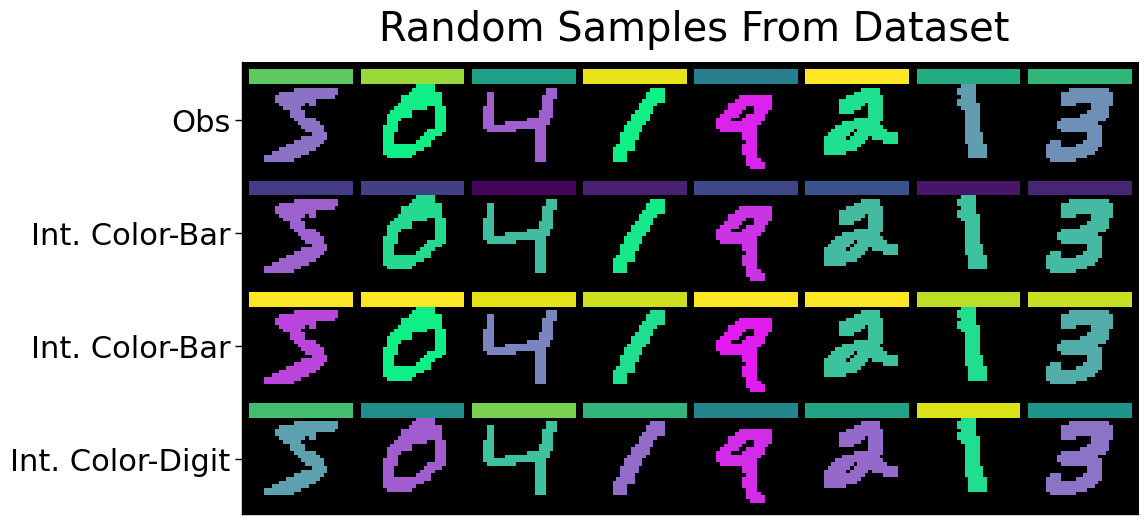

In [32]:
print(img_dataset.shape)
sns.set_context("paper", font_scale=2.5)
fig, ax = show_imgs(
    img_dataset,
    row_size=8,
    ytick_labels=["Obs", "Int. Color-Bar", "Int. Color-Bar", "Int. Color-Digit"],
)
fig.suptitle("Random Samples From Dataset", x=0.6, y=0.9)
fig.savefig("/Users/adam2392/Downloads/sample_dataset.pdf", bbox_inches="tight")

# Create the actual dataset and save to disc

In [34]:
img_dataset = []
labels_dataset = None

for intervention_idx in [0, 1, 2, 3]:
    causal_labels = bar_digit_scm(intervention_idx=intervention_idx, labels=labels)
    causal_labels["distr_idx"] = torch.Tensor([intervention_idx] * len(labels))

    # ensure all tensors are 2D so vstackable
    for key in keys:
        if causal_labels[key].ndim == 1:
            causal_labels[key] = causal_labels[key].reshape(-1, 1)

    if labels_dataset is None:
        labels_dataset = causal_labels
    else:
        keys = list(causal_labels.keys())
        for key in keys:
            labels_dataset[key] = torch.vstack(
                (labels_dataset[key], causal_labels[key])
            )

    for idx, img in enumerate(images):
        color_bar = causal_labels["color_bar"][idx]
        color_digit = causal_labels["color_digit"][idx]

        new_img = alter_digitbar_img(img, color_digit, color_bar)
        new_img = Image.fromarray(new_img, mode="RGB")
        img_dataset.append(new_img)


# img_dataset = torch.vstack(
#     [
#         torchvision.transforms.functional.pil_to_tensor(x).reshape(1, 3, 28, 28)
#         for x in img_dataset
#     ]
# )

# print(img_dataset.shape)
print(labels_dataset.keys())
keys = ["digit", "color_digit", "color_bar", "distr_idx"]
label_tensor = torch.zeros((len(img_dataset), len(keys)))
# convert the labels from a list of dictionaries to a tensor array
for idx, key in enumerate(keys):
    label_tensor[:, idx] = torch.Tensor(labels_dataset[key]).squeeze()
print(label_tensor.shape)

dict_keys(['intervention_targets', 'digit', 'color_digit', 'color_bar', 'distr_idx'])
torch.Size([240000, 4])


In [35]:
intervention_target_tensor = torch.zeros((len(img_dataset), 3), dtype=torch.int)
intervention_target_tensor[:] = torch.Tensor(labels_dataset["intervention_targets"])
print(intervention_target_tensor.shape)
print(root)

torch.Size([240000, 3])
/Users/adam2392/pytorch_data/


In [36]:
# save the actual data to disc now
root = Path(root)
imgs_fname = root / "CausalDigitBarMNIST" / "chainv2" / "chain-imgs-train.pt"
labels_fname = root / "CausalDigitBarMNIST" / "chainv2" / "chain-labels-train.pt"
targets_fname = root / "CausalDigitBarMNIST" / "chainv2" / "chain-targets-train.pt"
imgs_fname.parent.mkdir(exist_ok=True, parents=True)

torch.save(img_dataset, imgs_fname)
torch.save(label_tensor, labels_fname)
torch.save(intervention_target_tensor, targets_fname)

# V1 vs V2 dataset

V1 uses the datset from this commit: https://github.com/tree1111/CDRL/blob/digit_data_geenration/notebooks/dataset%20generate%20v2.ipynb

V2 uses a new dataset with more causal dependency